In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 20
BATCH_SIZE = 64
PATCH_DIMENSIONS = (128, 128)
DATA_LOCATION = r"D:\data\food"

# Transfer learning 101

In this notebook we will be using the food 101 dataset: https://www.kaggle.com/kmader/food41
We will just load the data in and resize it to 128x128 without looking to much into pre-processing or hyper parameter tuning given it is outside the scope of this session.

In this notebook we will freeze part of the model to reduse the number of weights we have to train.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(validation_split=0.3, horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1, rotation_range=15, zoom_range=0.5)
train_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="training")
validation_generator = data_generator.flow_from_directory(DATA_LOCATION, target_size=PATCH_DIMENSIONS, batch_size=BATCH_SIZE, subset="validation")

Found 70700 images belonging to 101 classes.
Found 30300 images belonging to 101 classes.


## Let's have a look at the data we are dealing with

We will vizualize 64 random images and there labels just to see what we are dealing with.
These image already have some data augmentation.

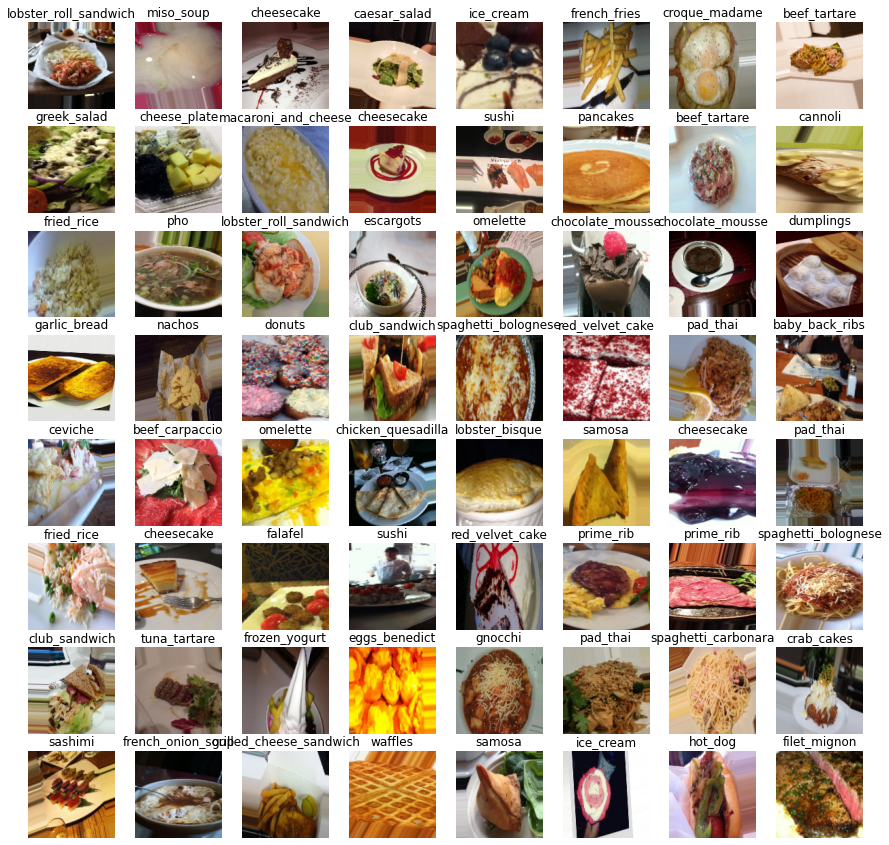

In [3]:
import matplotlib.pyplot as plt
import numpy as np
X, Y = train_generator.__getitem__(0)

classes = list(train_generator.class_indices.keys())
fig, axes = plt.subplots(8, 8,figsize=(15,15))
for x in range(8):
    for y in range(8):
        axes[x][y].imshow((X[x*8 + y]).astype("uint8"))
        class_num = int(np.argmax(Y[x*8 + y]))
        class_name = classes[class_num]
        axes[x][y].title.set_text(class_name)
        axes[x][y].axis('off')

plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have pre-trained weights VS random weights.

The model that is loaded is without a head because we only have 101 classes not thousands.

Also we add the option to freeze layers. That way their weights are not updated during training.

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(num_frozen_blocks: int = 0):
    n_classes = len(classes)
    pre_trained_model = EfficientNetB0(include_top=False, weights="imagenet")

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    all_layers = ["stem", "block1", "block2", "block3", "block4", "block5", "block6","block7", "top"]
    layers2freeze = tuple(all_layers[:num_frozen_blocks])
    for layer in model.layers:
        if layer.name.startswith(layers2freeze):
            layer.trainable = False

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model


## 4 frozen layers
We freeze the first 4 layers. There are not a lot of parameters in the first layers. But these are all very basic features. Meaning the chance these layers needs to be retrained is lower.

In [5]:
model_frozen_base = create_model(4)
history = model_frozen_base.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/20
1105/1105 [==============================] - 675s 611ms/step - loss: 2.5106 - accuracy: 0.4047 - val_loss: 1.9642 - val_accuracy: 0.5074
Epoch 2/20
1105/1105 [==============================] - 614s 556ms/step - loss: 1.7885 - accuracy: 0.5417 - val_loss: 1.7600 - val_accuracy: 0.5580
Epoch 3/20
1105/1105 [==============================] - 607s 550ms/step - loss: 1.5979 - accuracy: 0.5853 - val_loss: 1.7146 - val_accuracy: 0.5694
Epoch 4/20
1105/1105 [==============================] - 608s 550ms/step - loss: 1.4849 - accuracy: 0.6104 - val_loss: 1.6017 - val_accuracy: 0.5954
Epoch 5/20
1105/1105 [==============================] - 606s 548ms/step - loss: 1.3897 - accuracy: 0.6315 - val_loss: 1.5711 - val_accuracy: 0.6063
Epoch 6/20
1105/1105 [==============================] - 606s 548ms/step - loss: 1.3155 - accuracy: 0.6484 - val_loss: 1.5158 - val_accuracy: 0.6152
Epoch 7/20
1105/1105 [==============================] - 607s 550ms/step - loss: 1.2482 - accuracy: 0.6660 - val_

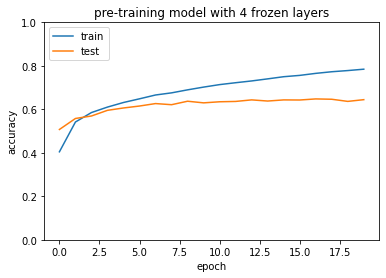

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 4 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

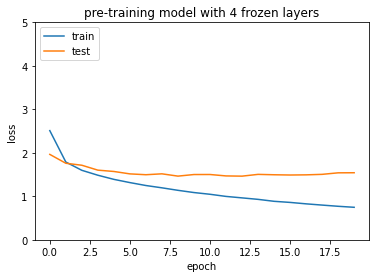

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 4 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 8 frozen layers
We freeze the first 8 layers. This are most of the layers but still less then half the parameters.

In [8]:
model_very_frozen = create_model(8)
history = model_very_frozen.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/20
1105/1105 [==============================] - 599s 542ms/step - loss: 3.1377 - accuracy: 0.3255 - val_loss: 2.5138 - val_accuracy: 0.4114
Epoch 2/20
1105/1105 [==============================] - 597s 541ms/step - loss: 2.3517 - accuracy: 0.4318 - val_loss: 2.2829 - val_accuracy: 0.4521
Epoch 3/20
1105/1105 [==============================] - 597s 541ms/step - loss: 2.1525 - accuracy: 0.4687 - val_loss: 2.1820 - val_accuracy: 0.4689
Epoch 4/20
1105/1105 [==============================] - 597s 541ms/step - loss: 2.0505 - accuracy: 0.4883 - val_loss: 2.1474 - val_accuracy: 0.4750
Epoch 5/20
1105/1105 [==============================] - 597s 540ms/step - loss: 1.9791 - accuracy: 0.5019 - val_loss: 2.1179 - val_accuracy: 0.4836
Epoch 6/20
1105/1105 [==============================] - 597s 541ms/step - loss: 1.9159 - accuracy: 0.5125 - val_loss: 2.0943 - val_accuracy: 0.4921
Epoch 7/20
1105/1105 [==============================] - 597s 541ms/step - loss: 1.8601 - accuracy: 0.5254 - val_

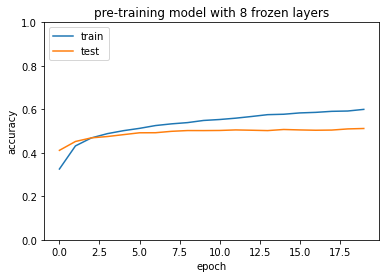

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 8 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

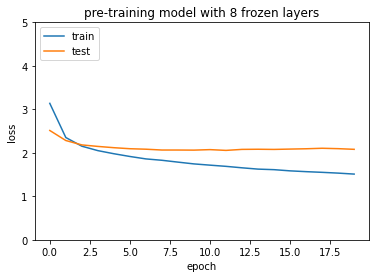

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 8 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model_completely_frozen = create_model(9)
history = model_completely_frozen.fit(train_generator,
            validation_data=validation_generator,
            epochs=N_EPOCHES)

Epoch 1/20
1105/1105 [==============================] - 599s 542ms/step - loss: 3.3234 - accuracy: 0.2945 - val_loss: 2.8292 - val_accuracy: 0.3748
Epoch 2/20
1105/1105 [==============================] - 598s 541ms/step - loss: 2.7553 - accuracy: 0.3839 - val_loss: 2.7068 - val_accuracy: 0.3956
Epoch 3/20
1105/1105 [==============================] - 598s 541ms/step - loss: 2.6410 - accuracy: 0.4027 - val_loss: 2.7527 - val_accuracy: 0.4001
Epoch 4/20
1105/1105 [==============================] - 600s 543ms/step - loss: 2.5686 - accuracy: 0.4174 - val_loss: 2.7068 - val_accuracy: 0.4058
Epoch 5/20
1105/1105 [==============================] - 597s 540ms/step - loss: 2.5404 - accuracy: 0.4234 - val_loss: 2.7410 - val_accuracy: 0.4087
Epoch 6/20
1105/1105 [==============================] - 597s 540ms/step - loss: 2.5158 - accuracy: 0.4296 - val_loss: 2.7170 - val_accuracy: 0.4137
Epoch 7/20
1105/1105 [==============================] - 597s 541ms/step - loss: 2.5143 - accuracy: 0.4320 - val_

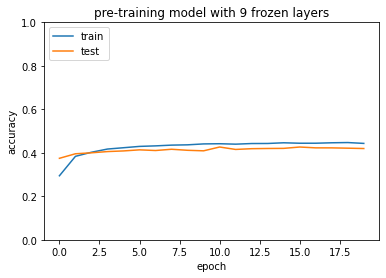

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 9 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

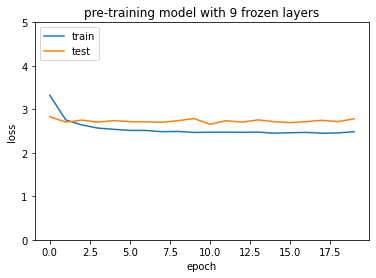

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 9 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()